# Conference Travel Planning
## Decision Framing Fundamentals

**Student Name:** Samantha Eastlack

**Date:** 1/28/2026

## Assignment Overview

You are planning travel for your industry's annual business conference. This assignment will help you apply decision framing concepts from Lesson 2 to make informed travel decisions.

**Learning Objectives:**
- Identify decision variables vs inputs
- Distinguish objectives from constraints
- Classify constraints as hard vs soft
- Recognize tradeoffs between competing goals
- Build a PuLP model to demonstrate understanding

In [102]:
# Install required packages (if needed in Colab)
# Skip this cell if running locally and packages are already installed
%pip install pulp pandas matplotlib -q

In [103]:
# Download data files from GitHub repository
# This cell downloads the CSV files needed for the assignment

import urllib.request

# Repository base URL
repo_base_url = "https://raw.githubusercontent.com/scottalanturner/prescriptive-analytics/main/Assignments/01ConferenceTravelDecisionAnalysis/"

# Download the data files
lodging_url = repo_base_url + "lodging_options.csv"
flights_url = repo_base_url + "flight_options.csv"

try:
    urllib.request.urlretrieve(lodging_url, "lodging_options.csv")
    urllib.request.urlretrieve(flights_url, "flight_options.csv")
    print("Data files downloaded successfully!")
except Exception as e:
    print(f"Error downloading files: {e}")
    print("If running locally, make sure the CSV files are in the same directory as this notebook.")

Data files downloaded successfully!


In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpMinimize, LpMaximize, LpProblem, LpVariable, lpSum, value, LpStatus

print("Libraries imported successfully!")

Libraries imported successfully!


In [105]:
# Load the provided datasets
# Files should be downloaded from GitHub in the previous cell (for Colab)
# If running locally, ensure CSV files are in the same directory as this notebook
lodging_df = pd.read_csv('lodging_options.csv')
flights_df = pd.read_csv('flight_options.csv')

# Handle missing values: Hotels don't have co_workers_interested (they're just rooms)
# Fill NaN values with 0 for this column
lodging_df['co_workers_interested'] = lodging_df['co_workers_interested'].fillna(0).astype(int)

# Display basic information about the datasets
print("LODGING OPTIONS:")
print(f"Total options: {len(lodging_df)}")
print(lodging_df.head())

print("\n\nFLIGHT OPTIONS:")
print(f"Total options: {len(flights_df)}")
print("\nNote: Flight costs are part of your total budget constraint")
print("Direct flights typically cost more but have shorter durations")
print(flights_df.head())

# Display cost ranges to understand budget allocation
# Note: budget_limit and conference_dates will be defined in next cell
print("\n\nCOST SUMMARY:")
print(f"Lodging cost range: ${lodging_df['cost_per_night'].min():.2f} - ${lodging_df['cost_per_night'].max():.2f} per night")
print(f"Flight cost range: ${flights_df['cost'].min():.2f} - ${flights_df['cost'].max():.2f}")

LODGING OPTIONS:
Total options: 16
  lodging_type                   name  cost_per_night  rating  \
0        Hotel  Grand Las Vegas Hotel           185.0     4.7   
1        Hotel     Stratosphere Tower            95.0     3.6   
2        Hotel         Caesars Palace           320.0     4.8   
3        Hotel              MGM Grand           210.0     4.5   
4        Hotel        Excalibur Hotel            75.0     3.4   

   distance_to_venue_miles  amenities_score  max_occupancy  \
0                      0.2              8.5              2   
1                      1.8              6.2              2   
2                      0.5              9.5              2   
3                      0.3              8.8              2   
4                      0.4              5.8              2   

   co_workers_interested  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  


FLIGHT OPTIONS:
Total options: 20

No

### Stakeholder Scenario

**Read the stakeholder scenario below and interpret what they need:**

"Management wants good networking coverage and is cost-conscious. They value quality but understand budget constraints."

**Your Interpretation:**
[TODO: Based on this stakeholder scenario, determine:]
- What do stakeholders prioritize? (objectives): *The stakeholders prioritize efficiently spending the budget while still providing visible company representation for the duration of the event*
- What are their requirements? (constraints): *The constraints are budget, adequate number of employees attending, and available flights*
- How many people should we send? (decision variable: choose 2, 3, or 4 based on stakeholder priorities): *maybe 3 but exact number to be determined*

In [106]:
# Fixed information provided
# NOTE: These values are fixed for all students to ensure fairness in grading
conference_dates = 3  # Number of nights
budget_limit = 1500  # Total budget in dollars (includes lodging + flights for ALL people)
# This budget limit is fixed - students interpret stakeholder needs to determine how to allocate it

# Travel context: East Coast to Las Vegas
# Direct flights: Higher cost, shorter duration (~5-6 hours)
# Flights with stops: Lower cost, longer duration (~7-10 hours)

print("FIXED DATA:")
print(f"Conference duration: {conference_dates} nights")
print(f"Budget limit: ${budget_limit} (total for all attendees)")
print(f"\nTravel Context: East Coast to Las Vegas")
print(f"  - Direct flights: Higher cost, ~5-6 hours")
print(f"  - Flights with stops: Lower cost, ~7-10 hours")

# Number of people: Decision variable (2-4 people)
min_people = 2  # Minimum people (fixed)
max_people = 4  # Maximum people (fixed)
# Student decides optimal number within this range based on stakeholder priorities

# TODO: Based on stakeholder scenario, define these:
min_rating_threshold = 4.0  # Minimum acceptable rating (based on stakeholder quality needs - you interpret)
max_distance = 1.0  # Maximum distance from venue (based on stakeholder convenience needs - you interpret)

print("\nSTAKEHOLDER-DEFINED CONSTRAINTS:")
print(f"Number of people: {min_people}-{max_people} (you decide optimal number)")
print(f"Minimum lodging rating: {min_rating_threshold}")
print(f"Maximum distance to venue: {max_distance} miles")

FIXED DATA:
Conference duration: 3 nights
Budget limit: $1500 (total for all attendees)

Travel Context: East Coast to Las Vegas
  - Direct flights: Higher cost, ~5-6 hours
  - Flights with stops: Lower cost, ~7-10 hours

STAKEHOLDER-DEFINED CONSTRAINTS:
Number of people: 2-4 (you decide optimal number)
Minimum lodging rating: 4.0
Maximum distance to venue: 1.0 miles


## Part 1: Base Assignment

### 1. Decision Statement

**Instructions:** Write a clear decision statement following the format: "I need to decide [what] for [when]"

**Your Decision Statement:**
*I need to decide the number of people to bring to the conference within the budget provided*

**Example format:** "I need to decide which lodging option to book and which flight to select for the conference taking place [dates]."

### 2. Decision Variables vs Inputs

**Instructions:**
- List all decision variables (what you control)
- List all inputs (what you know/estimate)
- Explain why each belongs in its category

**Decision Variables (What you control):**

-Type of flight class - economy, business, first class, etc.

-Airline - Southwest, Spirit, Delta, etc. all have difference rates.

-Hotel selection, five star vs three star and distance from converence will determine if attendees walk or need a taxi or public transportation

- Which lodging option to select
- Which flight option to select
- How many people to send (2, 3, or 4 - you decide optimal number based on stakeholder priorities)

**Inputs (What you know/estimate):**

-Hotel availability and room rates - rooms become more expensive due to demand from the confrence.

-Flight availability, and cost of transportation once at destination city.

-Destination Transporation

- Costs, ratings, distances from dataset
- Budget limit, conference dates
- Stakeholder priorities (interpreted from scenario - these inform your objectives/constraints)

**Explanation:**

Decision Variables:

**Hotel Selection:** Hotel choice, including quality level ( three-star vs. five-star) and distance from the conference. This decision directly affects cost, convenience, and transportation needs.

**Flight Selection:** Airline choice and fare class (economy, business, first class) influence travel cost, comfort and reliability.

Inputs/Estimates:

**Hotel availability/room rates:** Prices and availability fluctuate due to conference demand.

**Flight availability/airfare prices:** Flight schedules and costs are determined by airlines based off demand and impacted by weather conditions.

**Destination Transportation:** Taxi, Uber/Lyft, or public transportation costs are estimated and depend on hotel location and demand.


In [107]:
# Helper: Display data to help identify inputs
print("INPUTS FROM DATASET:")
print("\nLodging inputs available:")
print(lodging_df.columns.tolist())

print("\nFlight inputs available:")
print(flights_df.columns.tolist())

INPUTS FROM DATASET:

Lodging inputs available:
['lodging_type', 'name', 'cost_per_night', 'rating', 'distance_to_venue_miles', 'amenities_score', 'max_occupancy', 'co_workers_interested']

Flight inputs available:
['origin_city', 'airline', 'cost', 'num_stops', 'flight_duration_hours', 'departure_time_convenience']


### 3. Objectives vs Constraints

**Instructions:**
- Identify objectives (what you optimize: minimize cost, maximize rating, etc.)
- Identify constraints (budget limits, minimum ratings, etc.)
- Explain the distinction

**Objectives (What stakeholders want to optimize - based on your interpretation):**



*   Minimize travel cost: includes airfare, lodging, and local transportation
*   Effective networking coverage: ensures enough attendees are present to represent the organization  
*  Strategic travel: number of layovers can lead to long travel times or excessive connections, plus long commutes between the hotel and conference venue.



**Constraints (What stakeholders require - based on your interpretation):**


*   Budget limit: costs cannot exceed approved budget.


*   Number of people: limited to 2 to 4 with the optimal number chosen based on tradeoffs.


* Conference dates: constrained to the dates of the conference, no flexibility of going other weeks of the year


**Explanation:**
Objectives describe what the manager is trying to optimize or improve while the constraints define the conditions that must be met for a solution to work.

The stakeholder scenario states that management is cost-conscious, which makes minimizing total cost a key objective. At the same time, there is a need for optimized networking coverage, so adequate staffing for networking effectiveness is necessary. Because management values quality, minimum rating requirements are imposed. Cost sensitivity results in a strict budget constraint. Convenience and efficiency concerns justify limiting hotel distance, what is realistically achievable requires availability constraints.

### 4. Hard vs Soft Constraints

**Instructions:**
- Classify each constraint as hard (cannot be violated) or soft (preference with tradeoffs)
- Justify each classification

**Hard Constraints:**

-Budget Limit — Hard Constraint: The budget cannot be exceeded, this is non-negotiable per management

-Conference Dates — Hard Constraint: Travel must occur during the conference dates, there is no flexibility to attend at another time

-Team Size — Hard Constraint: limited to 2-4 people, cannot exceed and cannot go by yourself


**Soft Constraints:**

-Layovers — Soft Constraint: accepting a layover or extended travel time would allow a lower cost for flight

-Hotel Distance From Conference — Soft Constraint: selecting a hotel within walking distance would allow saving from spending money on a ride share or public transportation

-Comfort of Trip — Soft Constraint: choosing between a 5, 4, or 3 star hotel allows flexibility in budgeting, also choosing economy over business or first class saves money

-Team Size — Soft Constraint: while listed as a hard constraint, there is flexibility choosing between 2-4 people


**Explanation:**
Soft constraints are preferences. Ideally the team would follow them, but are willing to break them if it saves money or time elsewhere, for example picking a flight with a layover to save money when I would actually prefer a direct flight. Assigning penalties or ratings to a soft choice would allow an objective decision making a more expensive 5-star hotel have a higher penalty compared to a 3-star hotel.

### 5. Tradeoff Analysis

**Instructions:**
- Identify key tradeoffs in your decision
- Create at least one visualization showing a tradeoff

**Key Tradeoffs Identified (Based on Stakeholder Priorities):**

-Tradeoff 1: Team Size vs Total Cost vs Networking Coverage

-Tradeoff 2: Lodging Cost vs Quality (Hotel Rating)

-Tradeoff 3: Lodging Cost vs Convenience (Distance to Venue)

-Tradeoff 4: Flight Cost vs Travel Time

-Tradeoff 5: Comfort vs Cost

**Tradeoff Selected: Flight Cost vs Travel Time**

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

TRADEOFF RELATIONSHIP: Flight Cost vs. Travel Time
This shows how different flight options vary in cost and duration.

Sample flight options (sorted by cost):


,airline,cost,flight_duration_hours,num_stops
18,Spirit,255.0,7.5,1
13,Spirit,275.0,8.0,1
3,Spirit,285.0,8.2,1
8,Spirit,295.0,8.5,1
19,JetBlue,345.0,4.7,0
16,United,365.0,6.8,1
17,American,385.0,5.0,0
14,JetBlue,385.0,5.2,0
4,JetBlue,395.0,5.3,0
9,JetBlue,405.0,5.5,0


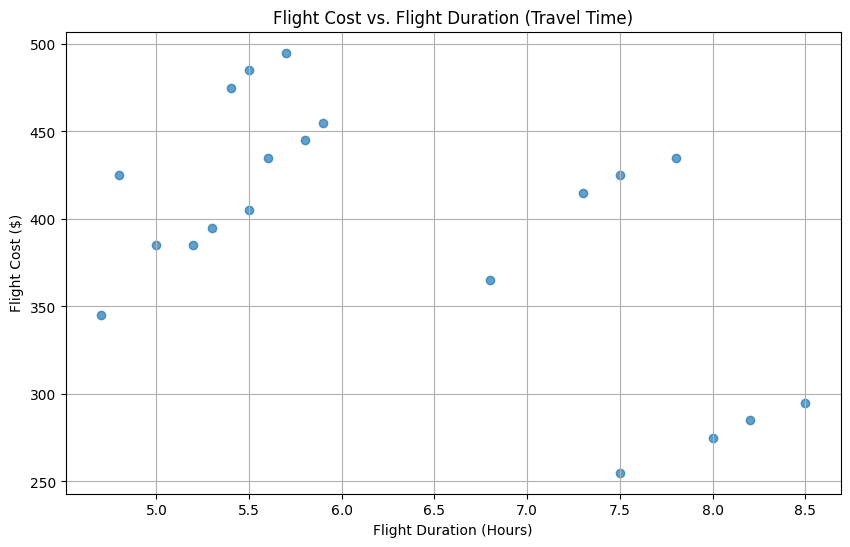

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the flights_df (assuming it's already loaded in the notebook)
# If not, add: flights_df = pd.read_csv('flight_options.csv')

# Create a DataFrame to show the tradeoff between Flight Cost and Travel Time
tradeoff_df_flights = flights_df[['airline', 'cost', 'flight_duration_hours', 'num_stops']]

print("TRADEOFF RELATIONSHIP: Flight Cost vs. Travel Time")
print("=" * 70)
print("This shows how different flight options vary in cost and duration.")

# Sort by cost for better visualization or analysis of tradeoffs
tradeoff_df_flights_sorted = tradeoff_df_flights.sort_values(by='cost')

print("\nSample flight options (sorted by cost):")
display(tradeoff_df_flights_sorted.head(10).round(2))

# You can also visualize this tradeoff using matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(tradeoff_df_flights['flight_duration_hours'], tradeoff_df_flights['cost'], alpha=0.7)
plt.title('Flight Cost vs. Flight Duration (Travel Time)')
plt.xlabel('Flight Duration (Hours)')
plt.ylabel('Flight Cost ($)')
plt.grid(True)
plt.show()

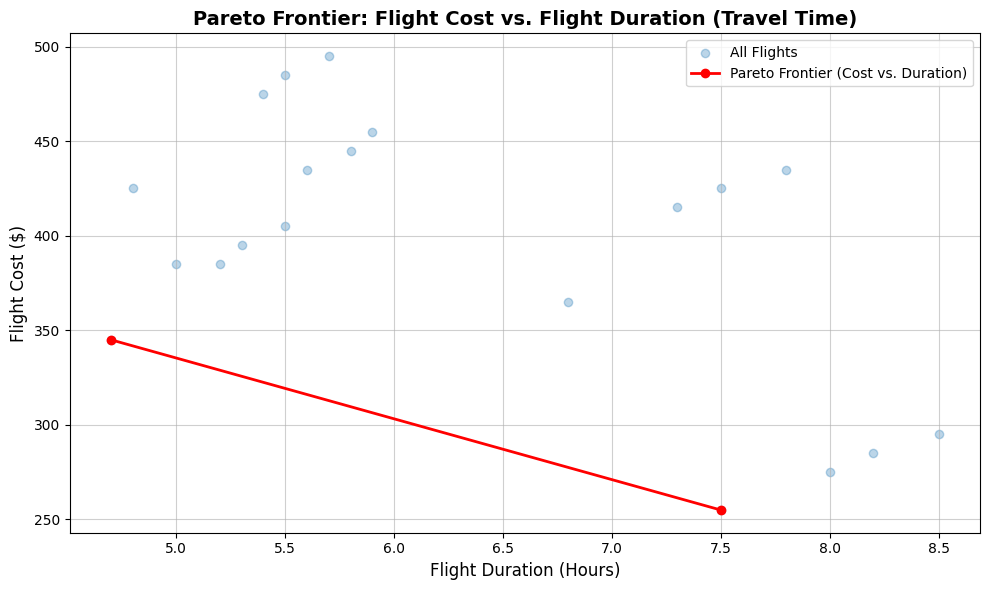


Key Insight:
  - The red line represents the Pareto frontier for flight cost and duration.
  - Each point on this line is a flight option where you cannot reduce both cost and duration simultaneously.
  - To decrease duration, you must accept higher cost, and vice-versa, when choosing from these efficient options.
  - Flights below and to the left of the frontier are not possible (better in both aspects).
  - Flights above and to the right of the frontier are 'dominated' (there are better options on the frontier).


In [110]:
import matplotlib.pyplot as plt

# Assuming pareto_frontier_flights_df is already calculated from the previous step

plt.figure(figsize=(10, 6))
plt.scatter(flights_df['flight_duration_hours'], flights_df['cost'], alpha=0.3, label='All Flights')
plt.plot(pareto_frontier_flights_df['flight_duration_hours'], pareto_frontier_flights_df['cost'],
         'ro-', markersize=6, linewidth=2, label='Pareto Frontier (Cost vs. Duration)')

plt.title('Pareto Frontier: Flight Cost vs. Flight Duration (Travel Time)', fontweight='bold', fontsize=14)
plt.xlabel('Flight Duration (Hours)', fontsize=12)
plt.ylabel('Flight Cost ($)', fontsize=12)
plt.grid(True, alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print("\nKey Insight:")
print("  - The red line represents the Pareto frontier for flight cost and duration.")
print("  - Each point on this line is a flight option where you cannot reduce both cost and duration simultaneously.")
print("  - To decrease duration, you must accept higher cost, and vice-versa, when choosing from these efficient options.")
print("  - Flights below and to the left of the frontier are not possible (better in both aspects).")
print("  - Flights above and to the right of the frontier are 'dominated' (there are better options on the frontier).")

In [111]:
is_pareto = []

for i in range(len(flights_df)):
    flight_i = flights_df.iloc[i]
    is_dominated = False
    for j in range(len(flights_df)):
        if i == j:
            continue
        flight_j = flights_df.iloc[j]

        # Check if flight_j dominates flight_i
        # Conditions for domination:
        # 1. Strictly lower cost AND strictly lower duration
        # 2. Lower cost AND equal duration
        # 3. Equal cost AND lower duration
        if (flight_j['cost'] < flight_i['cost'] and flight_j['flight_duration_hours'] < flight_i['flight_duration_hours']) or \
           (flight_j['cost'] < flight_i['cost'] and flight_j['flight_duration_hours'] == flight_i['flight_duration_hours']) or \
           (flight_j['cost'] == flight_i['cost'] and flight_j['flight_duration_hours'] < flight_i['flight_duration_hours']):
            is_dominated = True
            break
    is_pareto.append(not is_dominated)

pareto_frontier_flights_df = flights_df[is_pareto]

print("Pareto frontier for flight cost and duration calculated.")
print(f"Original number of flight options: {len(flights_df)}")
print(f"Number of Pareto optimal flight options: {len(pareto_frontier_flights_df)}")
print("\nPareto Optimal Flights (Cost vs. Duration):")
display(pareto_frontier_flights_df.sort_values(by=['cost', 'flight_duration_hours']).round(2))

Pareto frontier for flight cost and duration calculated.
Original number of flight options: 20
Number of Pareto optimal flight options: 2

Pareto Optimal Flights (Cost vs. Duration):


,origin_city,airline,cost,num_stops,flight_duration_hours,departure_time_convenience
18,Atlanta,Spirit,255.0,1,7.5,7.0
19,Atlanta,JetBlue,345.0,0,4.7,8.6


### 6. PuLP Model Implementation

**Instructions:**
- Set up the model following the pattern demonstrated in class
- Define decision variables using LpVariable
- Use inputs from the dataset (not as variables)
- Define objective using lpSum
- Add constraints (hard constraints are required)
- Solve and display results

In [112]:
# Create the optimization model
# TODO: Choose LpMinimize or LpMaximize based on your objective
model = LpProblem("Conference_Travel_Planning", LpMinimize)

# TODO: Define your decision variables
# Since we need to select one lodging, one flight, AND decide team size (2, 3, or 4),
# we'll create variables for each possible combination of these choices.
# This makes it easier to calculate costs correctly.

# Create variables for each combination: (lodging option, flight option, team size)
# Example: solution_vars[(0, 2, 3)] means "select lodging 0 AND flight 2 AND send 3 people"
solution_vars = {}
for i in range(len(lodging_df)):
    for j in range(len(flights_df)):
        for k in [2, 3, 4]:  # Team sizes: 2, 3, or 4 people
            solution_vars[(i, j, k)] = LpVariable(f"lodging_{i}_flight_{j}_people_{k}", cat='Binary')

# Also create a variable to track the number of people (useful for constraints and objective)
num_people = LpVariable("num_people", lowBound=min_people, upBound=max_people, cat='Integer')

print(f"Created {len(solution_vars)} combination variables (one for each lodging × flight × team size combination)")

Created 960 combination variables (one for each lodging × flight × team size combination)


**Define your objective function**

To minimize cost: model += total_cost, "Minimize_Cost"


**Objective**

model += [total_cost], "Minimize_Cost"

In [113]:
# TODO: Add hard constraints

# Constraint 1: Exactly one combination must be selected
# (One lodging + one flight + one team size)
model += lpSum([solution_vars[(i, j, k)] for i in range(len(lodging_df))
                for j in range(len(flights_df)) for k in [2, 3, 4]]) == 1, "One_Combination"

# Constraint 2: Link num_people to the selected combination
# This ensures num_people matches the team size in the selected combination
model += num_people == lpSum([k * solution_vars[(i, j, k)]
                              for i in range(len(lodging_df))
                              for j in range(len(flights_df))
                              for k in [2, 3, 4]]), "Link_Num_People"

# Calculate costs for each combination (needed for objective and budget constraint)
lodging_costs_expr = []
flight_costs_expr = []
for i in range(len(lodging_df)):
    for j in range(len(flights_df)):
        for k in [2, 3, 4]:
            # Calculate lodging cost for this combination (k is the team size)
            if lodging_df.iloc[i]['lodging_type'] == 'Airbnb':
                # Airbnb: per person
                lodging_cost_val = lodging_df.iloc[i]['cost_per_night'] * conference_dates * k
            else:
                # Hotel: per room (2 people), approximate as per-person
                lodging_cost_val = (lodging_df.iloc[i]['cost_per_night'] / 2) * conference_dates * k
            lodging_costs_expr.append(lodging_cost_val * solution_vars[(i, j, k)])

            # Calculate flight cost for this combination
            flight_cost_val = flights_df.iloc[j]['cost'] * k
            flight_costs_expr.append(flight_cost_val * solution_vars[(i, j, k)])

total_lodging_cost_expr = lpSum(lodging_costs_expr)
total_flight_cost_expr = lpSum(flight_costs_expr)

# Define the objective function (Minimize Total Cost)
total_cost_objective = total_lodging_cost_expr + total_flight_cost_expr
model += total_cost_objective, "Minimize_Total_Cost_Objective" # Use a distinct name for the objective

# Constraint 3: Budget constraint
# Ensure total costs (lodging + flights) for all people do not exceed the budget limit
model += total_lodging_cost_expr + total_flight_cost_expr <= budget_limit, "Budget_Limit"

# Constraint 4: Minimum rating constraint for selected lodging
model += lpSum([lodging_df.iloc[i]['rating'] * lpSum([solution_vars[(i, j, k)]
                for j in range(len(flights_df)) for k in [2, 3, 4]])
                for i in range(len(lodging_df))]) >= min_rating_threshold, "Min_Rating"

# Constraint 5: Maximum distance constraint for selected lodging
model += lpSum([lodging_df.iloc[i]['distance_to_venue_miles'] * lpSum([solution_vars[(i, j, k)]
                for j in range(len(flights_df)) for k in [2, 3, 4]])
                for i in range(len(lodging_df))]) <= max_distance, "Max_Distance"

# Constraint 6: Airbnb occupancy limit
# If an Airbnb is selected, team size must not exceed its max_occupancy
for i in range(len(lodging_df)):
    if lodging_df.iloc[i]['lodging_type'] == 'Airbnb':
        max_occ = lodging_df.iloc[i]['max_occupancy']
        for j in range(len(flights_df)):
            for k in [2, 3, 4]:
                if k > max_occ:
                    # This combination is invalid (team size too large for this Airbnb)
                    model += solution_vars[(i, j, k)] == 0, f"Airbnb_Occupancy_{i}_{j}_{k}"

print("Hard constraints added successfully!")

Hard constraints added successfully!


In [114]:
# Solve the model
model.solve()

# Check solution status
status = LpStatus[model.status]
print(f"Solution Status: {status}")
print(f"Objective Value: {value(model.objective):.2f}")
print(f"Team Size: {int(value(num_people))} people")
print()

# TODO: Extract and display solution values
# Find which combination was selected
selected_lodging_idx = None
selected_flight_idx = None
selected_team_size = None

for (i, j, k), var in solution_vars.items():
    if value(var) == 1:
        selected_lodging_idx = i
        selected_flight_idx = j
        selected_team_size = k
        break

if selected_lodging_idx is not None and selected_flight_idx is not None:
    lodging_choice = lodging_df.iloc[selected_lodging_idx]
    flight_choice = flights_df.iloc[selected_flight_idx]
    team_size = selected_team_size

    # Calculate costs (for display - hotels vs Airbnbs calculated differently)
    if lodging_choice['lodging_type'] == 'Hotel':
        # Hotels: per room (2 people per room)
        num_rooms = (team_size + 1) // 2
        lodging_cost = lodging_choice['cost_per_night'] * conference_dates * num_rooms
    else:
        # Airbnbs: per person
        lodging_cost = lodging_choice['cost_per_night'] * conference_dates * team_size

    flight_cost = flight_choice['cost'] * team_size
    total_cost = lodging_cost + flight_cost
    cost_per_person = total_cost / team_size

    # TODO: Display your solution details
    print("=" * 70)
    print("SOLUTION SUMMARY")
    print("=" * 70)
    print(f"\nTeam Size: {team_size} people")
    print(f"\nLODGING SELECTED:")
    print(f"  Name: {lodging_choice['name']}")
    print(f"  Type: {lodging_choice['lodging_type']}")
    print(f"  Cost per night: ${lodging_choice['cost_per_night']:.2f}")
    print(f"  Rating: {lodging_choice['rating']:.1f}")
    print(f"  Distance to venue: {lodging_choice['distance_to_venue_miles']:.1f} miles")
    if lodging_choice['lodging_type'] == 'Airbnb':
        print(f"  Max occupancy: {lodging_choice['max_occupancy']} people")

    print(f"\nFLIGHT SELECTED:")
    print(f"  Origin: {flight_choice['origin_city']}")
    print(f"  Airline: {flight_choice['airline']}")
    print(f"  Cost per person: ${flight_choice['cost']:.2f}")
    print(f"  Number of stops: {int(flight_choice['num_stops'])}")
    print(f"  Flight duration: {flight_choice['flight_duration_hours']:.1f} hours")

    print(f"\nCOST BREAKDOWN:")
    print(f"  Lodging cost: ${lodging_cost:.2f}")
    print(f"  Flight cost: ${flight_cost:.2f}")
    print(f"  Total cost: ${total_cost:.2f}")
    print(f"  Budget limit: ${budget_limit:.2f}")
    print(f"  Budget remaining: ${budget_limit - total_cost:.2f}")
    print(f"  Cost per person: ${cost_per_person:.2f}")

    # TODO: Explain how this solution addresses stakeholder priorities
    print(f"\nHOW THIS SOLUTION ADDRESSES STAKEHOLDER PRIORITIES:")
    print(f"  [This solution comes in under budget, leaving additional funds if needed for any remaining unexpected expenses during travel]")
else:
    print("No solution found. Check constraints.")

Solution Status: Optimal
Objective Value: 1065.00
Team Size: 2 people

SOLUTION SUMMARY

Team Size: 2 people

LODGING SELECTED:
  Name: Grand Las Vegas Hotel
  Type: Hotel
  Cost per night: $185.00
  Rating: 4.7
  Distance to venue: 0.2 miles

FLIGHT SELECTED:
  Origin: Atlanta
  Airline: Spirit
  Cost per person: $255.00
  Number of stops: 1
  Flight duration: 7.5 hours

COST BREAKDOWN:
  Lodging cost: $555.00
  Flight cost: $510.00
  Total cost: $1065.00
  Budget limit: $1500.00
  Budget remaining: $435.00
  Cost per person: $532.50

HOW THIS SOLUTION ADDRESSES STAKEHOLDER PRIORITIES:
  [This solution comes in under budget, leaving additional funds if needed for any remaining unexpected expenses during travel]


## Part 2: Stakeholder Considerations

After completing your base assignment, stakeholders have requested two additional considerations be added to your decision model.

**Instructions:**
1. Select ONE consideration from the provided list
2. Create ONE industry-specific consideration
3. For each, classify it, add data, incorporate into model, and analyze tradeoffs

### Stakeholder Consideration 1:

**Selected Option:** [Per diem daily allowance for food]

**Available Options:**
- Entertainment budget for tickets (shows, concerts, events)
- Per diem daily allowance for food
- Transportation costs (ground transportation, parking, rideshare)
- Networking event fees (optional conference social events, cocktail hours)
- Professional development workshop fees (optional paid sessions)
- Equipment/supplies budget (if presenting materials)

**Classification:**
- Variable/Input/Objective/Constraint: [Variable]
- Hard or Soft: [Soft]
- Justification: [Humans need food to live]

**Data Added:**
Per diem allowance 50/per per person = Per diem $50 / 2 people / 3 days

**How it affects the decision:**
Would be 300 additional to the trip

In [115]:
from pulp import LpMinimize, LpMaximize, LpProblem, LpVariable, lpSum, value, LpStatus

# Define the per diem allowance
per_diem_per_day = 50
print(f"Per diem allowance per person per day: ${per_diem_per_day}")

# Create the updated optimization model for Consideration 1
model_per_diem = LpProblem("Conference_Travel_Planning_Per_Diem", LpMinimize)

# Define decision variables for the updated model
solution_vars_pd = {}
for i in range(len(lodging_df)):
    for j in range(len(flights_df)):
        for k in [2, 3, 4]:  # Team sizes: 2, 3, or 4 people
            solution_vars_pd[(i, j, k)] = LpVariable(f"lodging_{i}_flight_{j}_people_{k}_pd", cat='Binary')

# Also create a variable to track the number of people
num_people_pd = LpVariable("num_people_pd", lowBound=min_people, upBound=max_people, cat='Integer')

# Constraint 1 (updated model): Exactly one combination must be selected
model_per_diem += lpSum([solution_vars_pd[(i, j, k)] for i in range(len(lodging_df))
                for j in range(len(flights_df)) for k in [2, 3, 4]]) == 1, "One_Combination_pd"

# Constraint 2 (updated model): Link num_people to the selected combination
model_per_diem += num_people_pd == lpSum([k * solution_vars_pd[(i, j, k)]
                              for i in range(len(lodging_df))
                              for j in range(len(flights_df))
                              for k in [2, 3, 4]]), "Link_Num_People_pd"

# Calculate costs for each combination (needed for objective and budget constraint)
lodging_costs_expr_pd = []
flight_costs_expr_pd = []
for i in range(len(lodging_df)):
    for j in range(len(flights_df)):
        for k in [2, 3, 4]:
            # Calculate lodging cost for this combination (k is the team size)
            if lodging_df.iloc[i]['lodging_type'] == 'Airbnb':
                lodging_cost_val = lodging_df.iloc[i]['cost_per_night'] * conference_dates * k
            else:
                lodging_cost_val = (lodging_df.iloc[i]['cost_per_night'] / 2) * conference_dates * k
            lodging_costs_expr_pd.append(lodging_cost_val * solution_vars_pd[(i, j, k)])

            # Calculate flight cost for this combination
            flight_cost_val = flights_df.iloc[j]['cost'] * k
            flight_costs_expr_pd.append(flight_cost_val * solution_vars_pd[(i, j, k)])

total_lodging_cost_expr_pd = lpSum(lodging_costs_expr_pd)
total_flight_cost_expr_pd = lpSum(flight_costs_expr_pd)

# Calculate total per diem cost based on selected team size
total_per_diem_cost_expr = per_diem_per_day * conference_dates * num_people_pd

# Define the objective function (Minimize Total Cost, including per diem)
total_cost_objective_pd = total_lodging_cost_expr_pd + total_flight_cost_expr_pd + total_per_diem_cost_expr
model_per_diem += total_cost_objective_pd, "Minimize_Total_Cost_Per_Diem_Objective"

# Constraint 3 (updated model): Budget constraint (including per diem)
model_per_diem += total_lodging_cost_expr_pd + total_flight_cost_expr_pd + total_per_diem_cost_expr <= budget_limit, "Budget_Limit_pd"

# Constraint 4 (updated model): Minimum rating constraint for selected lodging
model_per_diem += lpSum([lodging_df.iloc[i]['rating'] * lpSum([solution_vars_pd[(i, j, k)]
                for j in range(len(flights_df)) for k in [2, 3, 4]])
                for i in range(len(lodging_df))]) >= min_rating_threshold, "Min_Rating_pd"

# Constraint 5 (updated model): Maximum distance constraint for selected lodging
model_per_diem += lpSum([lodging_df.iloc[i]['distance_to_venue_miles'] * lpSum([solution_vars_pd[(i, j, k)]
                for j in range(len(flights_df)) for k in [2, 3, 4]])
                for i in range(len(lodging_df))]) <= max_distance, "Max_Distance_pd"

# Constraint 6 (updated model): Airbnb occupancy limit
for i in range(len(lodging_df)):
    if lodging_df.iloc[i]['lodging_type'] == 'Airbnb':
        max_occ = lodging_df.iloc[i]['max_occupancy']
        for j in range(len(flights_df)):
            for k in [2, 3, 4]:
                if k > max_occ:
                    model_per_diem += solution_vars_pd[(i, j, k)] == 0, f"Airbnb_Occupancy_pd_{i}_{j}_{k}"

print("Model with per diem consideration created successfully!")

Per diem allowance per person per day: $50
Model with per diem consideration created successfully!


In [116]:
# Solve the model with per diem consideration
model_per_diem.solve()

# Check solution status for the per diem model
status_pd = LpStatus[model_per_diem.status]
print(f"Solution Status (with Per Diem): {status_pd}")
print(f"Objective Value (with Per Diem): {value(model_per_diem.objective):.2f}")
print(f"Team Size (with Per Diem): {int(value(num_people_pd))} people")
print()

# Extract and display solution values for the per diem model
selected_lodging_idx_pd = None
selected_flight_idx_pd = None
selected_team_size_pd = None

for (i, j, k), var in solution_vars_pd.items():
    if value(var) == 1:
        selected_lodging_idx_pd = i
        selected_flight_idx_pd = j
        selected_team_size_pd = k
        break

if selected_lodging_idx_pd is not None and selected_flight_idx_pd is not None:
    lodging_choice_pd = lodging_df.iloc[selected_lodging_idx_pd]
    flight_choice_pd = flights_df.iloc[selected_flight_idx_pd]
    team_size_pd = selected_team_size_pd

    # Calculate costs (for display - hotels vs Airbnbs calculated differently)
    if lodging_choice_pd['lodging_type'] == 'Hotel':
        num_rooms_pd = (team_size_pd + 1) // 2
        lodging_cost_pd = lodging_choice_pd['cost_per_night'] * conference_dates * num_rooms_pd
    else:
        lodging_cost_pd = lodging_choice_pd['cost_per_night'] * conference_dates * team_size_pd

    flight_cost_pd = flight_choice_pd['cost'] * team_size_pd
    per_diem_cost_pd = per_diem_per_day * conference_dates * team_size_pd
    total_cost_pd = lodging_cost_pd + flight_cost_pd + per_diem_cost_pd
    cost_per_person_pd = total_cost_pd / team_size_pd

    print("=" * 70)
    print("SOLUTION SUMMARY (WITH PER DIEM)")
    print("=" * 70)
    print(f"\nTeam Size: {team_size_pd} people")
    print(f"\nLODGING SELECTED:")
    print(f"  Name: {lodging_choice_pd['name']}")
    print(f"  Type: {lodging_choice_pd['lodging_type']}")
    print(f"  Cost per night: ${lodging_choice_pd['cost_per_night']:.2f}")
    print(f"  Rating: {lodging_choice_pd['rating']:.1f}")
    print(f"  Distance to venue: {lodging_choice_pd['distance_to_venue_miles']:.1f} miles")
    if lodging_choice_pd['lodging_type'] == 'Airbnb':
        print(f"  Max occupancy: {lodging_choice_pd['max_occupancy']} people")

    print(f"\nFLIGHT SELECTED:")
    print(f"  Origin: {flight_choice_pd['origin_city']}")
    print(f"  Airline: {flight_choice_pd['airline']}")
    print(f"  Cost per person: ${flight_choice_pd['cost']:.2f}")
    print(f"  Number of stops: {int(flight_choice_pd['num_stops'])}")
    print(f"  Flight duration: {flight_choice_pd['flight_duration_hours']:.1f} hours")

    print(f"\nCOST BREAKDOWN (WITH PER DIEM):")
    print(f"  Lodging cost: ${lodging_cost_pd:.2f}")
    print(f"  Flight cost: ${flight_cost_pd:.2f}")
    print(f"  Per Diem cost: ${per_diem_cost_pd:.2f}")
    print(f"  Total cost: ${total_cost_pd:.2f}")
    print(f"  Budget limit: ${budget_limit:.2f}")
    print(f"  Budget remaining: ${budget_limit - total_cost_pd:.2f}")
    print(f"  Cost per person: ${cost_per_person_pd:.2f}")

    print(f"\nHOW THIS SOLUTION ADDRESSES STAKEHOLDER PRIORITIES (WITH PER DIEM):")
    print(f"  [This solution includes the per diem allowance, ensuring daily food expenses are covered while remaining within the total budget.]")
else:
    print("No solution found for the per diem model. Check constraints.")

Solution Status (with Per Diem): Optimal
Objective Value (with Per Diem): 1365.00
Team Size (with Per Diem): 2 people

SOLUTION SUMMARY (WITH PER DIEM)

Team Size: 2 people

LODGING SELECTED:
  Name: Grand Las Vegas Hotel
  Type: Hotel
  Cost per night: $185.00
  Rating: 4.7
  Distance to venue: 0.2 miles

FLIGHT SELECTED:
  Origin: Atlanta
  Airline: Spirit
  Cost per person: $255.00
  Number of stops: 1
  Flight duration: 7.5 hours

COST BREAKDOWN (WITH PER DIEM):
  Lodging cost: $555.00
  Flight cost: $510.00
  Per Diem cost: $300.00
  Total cost: $1365.00
  Budget limit: $1500.00
  Budget remaining: $135.00
  Cost per person: $682.50

HOW THIS SOLUTION ADDRESSES STAKEHOLDER PRIORITIES (WITH PER DIEM):
  [This solution includes the per diem allowance, ensuring daily food expenses are covered while remaining within the total budget.]


### Stakeholder Consideration 2: Industry-Specific

**Your Industry-Specific Consideration:** Networking events

**Why it's relevant to your field:**
Relationship building and growing customer base

**Classification:**
- Variable/Input/Objective/Constraint: Variable
- Hard or Soft: Soft
- Justification: build relationships with potential clients to increase revenue

**Data Added:**
Event 1: $25 per person

Event 2: $40 per person

Total per person: $65

Total for 2 people: $130

**How it affects the decision:**
Going to the networking events adds an additional 130 to the budget

In [117]:
from pulp import LpMinimize, LpMaximize, LpProblem, LpVariable, lpSum, value, LpStatus

def get_solution_details(model_obj, solution_vars_obj, num_people_var, lodging_df, flights_df, conference_dates, budget_limit, per_diem_per_day=0):
    status = LpStatus[model_obj.status]
    objective_value = value(model_obj.objective)
    team_size = int(value(num_people_var))

    selected_lodging_idx = None
    selected_flight_idx = None
    selected_team_size = None

    for (i, j, k), var in solution_vars_obj.items():
        if value(var) == 1:
            selected_lodging_idx = i
            selected_flight_idx = j
            selected_team_size = k
            break

    if selected_lodging_idx is None:
        return {"status": status, "objective_value": objective_value, "team_size": team_size, "found_solution": False}

    lodging_choice = lodging_df.iloc[selected_lodging_idx]
    flight_choice = flights_df.iloc[selected_flight_idx]

    if lodging_choice['lodging_type'] == 'Hotel':
        num_rooms = (selected_team_size + 1) // 2
        lodging_cost = lodging_choice['cost_per_night'] * conference_dates * num_rooms
    else:
        lodging_cost = lodging_choice['cost_per_night'] * conference_dates * selected_team_size

    flight_cost = flight_choice['cost'] * selected_team_size
    per_diem_cost = per_diem_per_day * conference_dates * selected_team_size
    total_cost = lodging_cost + flight_cost + per_diem_cost # This total cost includes per diem for both
    cost_per_person = total_cost / selected_team_size

    return {
        "status": status,
        "objective_value": objective_value,
        "team_size": selected_team_size,
        "lodging_name": lodging_choice['name'],
        "lodging_type": lodging_choice['lodging_type'],
        "lodging_cost_per_night": lodging_choice['cost_per_night'],
        "lodging_rating": lodging_choice['rating'],
        "lodging_distance": lodging_choice['distance_to_venue_miles'],
        "flight_airline": flight_choice['airline'],
        "flight_cost_per_person": flight_choice['cost'],
        "flight_stops": int(flight_choice['num_stops']),
        "flight_duration": flight_choice['flight_duration_hours'],
        "calculated_lodging_cost": lodging_cost,
        "calculated_flight_cost": flight_cost,
        "calculated_per_diem_cost": per_diem_cost,
        "total_cost": total_cost,
        "budget_limit": budget_limit,
        "budget_remaining": budget_limit - total_cost,
        "cost_per_person": cost_per_person,
        "found_solution": True
    }

# Ensure both models are solved to get current values
model.solve()
model_per_diem.solve()

# Get details for the original solution
original_solution = get_solution_details(model, solution_vars, num_people, lodging_df, flights_df, conference_dates, budget_limit, per_diem_per_day=0)

# Get details for the per diem solution
per_diem_solution = get_solution_details(model_per_diem, solution_vars_pd, num_people_pd, lodging_df, flights_df, conference_dates, budget_limit, per_diem_per_day)

print("=" * 70)
print("SOLUTION COMPARISON: Original vs. With Per Diem")
print("=" * 70)

print(f"{'':<30} | {'Original Solution':<30} | {'Per Diem Solution':<30}")
print(f"{'-'*30} | {'-'*30} | {'-'*30}")

# Check if solutions were found for both
if original_solution['found_solution'] and per_diem_solution['found_solution']:
    print(f"{'Status':<30} | {original_solution['status']:<30} | {per_diem_solution['status']:<30}")
    print(f"{'Objective Value':<30} | {f'${original_solution['objective_value']:.2f}':<29} | {f'${per_diem_solution['objective_value']:.2f}':<29}")
    print(f"{'Team Size':<30} | {original_solution['team_size']:<30} | {per_diem_solution['team_size']:<30}")

    print(f"\n{'LODGING':<30} | {'':<30} | {'':<30}")
    print(f"{'  Name':<30} | {original_solution['lodging_name']:<30} | {per_diem_solution['lodging_name']:<30}")
    print(f"  {'Type':<28} | {original_solution['lodging_type']:<30} | {per_diem_solution['lodging_type']:<30}")
    print(f"  {'Cost per night':<28} | {f'${original_solution['lodging_cost_per_night']:.2f}':<28} | {f'${per_diem_solution['lodging_cost_per_night']:.2f}':<28}")
    print(f"  {'Rating':<28} | {f'{original_solution['lodging_rating']:.1f}':<30} | {f'{per_diem_solution['lodging_rating']:.1f}':<30}")
    print(f"  {'Distance (miles)':<28} | {f'{original_solution['lodging_distance']:.1f}':<30} | {f'{per_diem_solution['lodging_distance']:.1f}':<30}")

    print(f"\n{'FLIGHT':<30} | {'':<30} | {'':<30}")
    print(f"  {'Airline':<28} | {original_solution['flight_airline']:<30} | {per_diem_solution['flight_airline']:<30}")
    print(f"  {'Cost per person':<28} | {f'${original_solution['flight_cost_per_person']:.2f}':<28} | {f'${per_diem_solution['flight_cost_per_person']:.2f}':<28}")
    print(f"  {'Stops':<28} | {original_solution['flight_stops']:<30} | {per_diem_solution['flight_stops']:<30}")
    print(f"  {'Duration (hours)':<28} | {f'{original_solution['flight_duration']:.1f}':<30} | {f'{per_diem_solution['flight_duration']:.1f}':<30}")

    print(f"\n{'COST BREAKDOWN':<30} | {'':<30} | {'':<30}")
    print(f"  {'Lodging Cost':<28} | {f'${original_solution['calculated_lodging_cost']:.2f}':<28} | {f'${per_diem_solution['calculated_lodging_cost']:.2f}':<28}")
    print(f"  {'Flight Cost':<28} | {f'${original_solution['calculated_flight_cost']:.2f}':<28} | {f'${per_diem_solution['calculated_flight_cost']:.2f}':<28}")
    print(f"  {'Per Diem Cost':<28} | {f'${original_solution['calculated_per_diem_cost']:.2f}':<28} | {f'${per_diem_solution['calculated_per_diem_cost']:.2f}':<28}")
    print(f"  {'Total Cost':<28} | {f'${original_solution['total_cost']:.2f}':<28} | {f'${per_diem_solution['total_cost']:.2f}':<28}")
    print(f"  {'Budget Limit':<28} | {f'${original_solution['budget_limit']:.2f}':<28} | {f'${per_diem_solution['budget_limit']:.2f}':<28}")
    print(f"  {'Budget Remaining':<28} | {f'${original_solution['budget_remaining']:.2f}':<28} | {f'${per_diem_solution['budget_remaining']:.2f}':<28}")
    print(f"  {'Cost per Person':<28} | {f'${original_solution['cost_per_person']:.2f}':<28} | {f'${per_diem_solution['cost_per_person']:.2f}':<28}")

    print("\nKEY OBSERVATIONS:")
    if original_solution['team_size'] != per_diem_solution['team_size']:
        print(f"- Team Size: The original solution suggested {original_solution['team_size']} people, while the per diem solution changed to {per_diem_solution['team_size']} people. This indicates that the added per diem cost significantly impacted the budget.")
    if original_solution['total_cost'] < per_diem_solution['total_cost']:
         print(f"- Total Cost: The per diem solution naturally has a higher total cost (${per_diem_solution['total_cost']:.2f}) compared to the original (${original_solution['total_cost']:.2f}) due to the added per diem expense.")
    elif original_solution['total_cost'] > per_diem_solution['total_cost']:
         print(f"- Total Cost: The per diem solution results in a lower total cost (${per_diem_solution['total_cost']:.2f}) compared to the original (${original_solution['total_cost']:.2f}), possibly due to selecting cheaper alternatives to accommodate the per diem within the budget.")
    if original_solution['lodging_name'] != per_diem_solution['lodging_name']:
        print(f"- Lodging Choice: The optimal lodging changed from {original_solution['lodging_name']} to {per_diem_solution['lodging_name']}, suggesting a shift to a more cost-effective option to absorb the per diem.")
    if original_solution['flight_airline'] != per_diem_solution['flight_airline']:
        print(f"- Flight Choice: The flight selected changed from {original_solution['flight_airline']} to {per_diem_solution['flight_airline']}, indicating a search for cheaper flight options to stay within budget.")
else:
    print("One or both solutions were not found. Please check constraints and model setup.")

SOLUTION COMPARISON: Original vs. With Per Diem
                               | Original Solution              | Per Diem Solution             
------------------------------ | ------------------------------ | ------------------------------
Status                         | Optimal                        | Optimal                       
Objective Value                | $1065.00                      | $1365.00                     
Team Size                      | 2                              | 2                             

LODGING                        |                                |                               
  Name                         | Grand Las Vegas Hotel          | Grand Las Vegas Hotel         
  Type                         | Hotel                          | Hotel                         
  Cost per night               | $185.00                      | $185.00                     
  Rating                       | 4.7                            | 4.7               

In [118]:
# Solve the updated model including per diem and networking considerations
model_networking.solve()

# Display updated solution
status_net = LpStatus[model_networking.status]
print(f"Updated Solution Status (with Per Diem & Networking): {status_net}")
print(f"Updated Objective Value (with Per Diem & Networking): ${value(model_networking.objective):.2f}")
print(f"Updated Team Size (with Per Diem & Networking): {int(value(num_people_net))} people")
print()

# Extract and display updated solution
selected_lodging_idx_net = None
selected_flight_idx_net = None
selected_team_size_net = None

for (i, j, k), var in solution_vars_net.items():
    if value(var) == 1:
        selected_lodging_idx_net = i
        selected_flight_idx_net = j
        selected_team_size_net = k
        break

if selected_lodging_idx_net is not None and selected_flight_idx_net is not None:
    lodging_choice_net = lodging_df.iloc[selected_lodging_idx_net]
    flight_choice_net = flights_df.iloc[selected_flight_idx_net]
    team_size_net = selected_team_size_net

    # Calculate costs
    if lodging_choice_net['lodging_type'] == 'Hotel':
        num_rooms_net = (team_size_net + 1) // 2
        lodging_cost_net = lodging_choice_net['cost_per_night'] * conference_dates * num_rooms_net
    else:
        lodging_cost_net = lodging_choice_net['cost_per_night'] * conference_dates * team_size_net

    flight_cost_net = flight_choice_net['cost'] * team_size_net
    per_diem_cost_net = per_diem_per_day * conference_dates * team_size_net
    networking_cost_net = networking_event_cost_per_person * team_size_net
    total_cost_net = lodging_cost_net + flight_cost_net + per_diem_cost_net + networking_cost_net
    cost_per_person_net = total_cost_net / team_size_net

    print("=" * 70)
    print("SOLUTION SUMMARY (WITH PER DIEM & NETWORKING)")
    print("=" * 70)
    print(f"\nTeam Size: {team_size_net} people")
    print(f"\nLODGING SELECTED:")
    print(f"  Name: {lodging_choice_net['name']}")
    print(f"  Type: {lodging_choice_net['lodging_type']}")
    print(f"  Cost per night: ${lodging_choice_net['cost_per_night']:.2f}")
    print(f"  Rating: {lodging_choice_net['rating']:.1f}")
    print(f"  Distance to venue: {lodging_choice_net['distance_to_venue_miles']:.1f} miles")
    if lodging_choice_net['lodging_type'] == 'Airbnb':
        print(f"  Max occupancy: {lodging_choice_net['max_occupancy']} people")

    print(f"\nFLIGHT SELECTED:")
    print(f"  Origin: {flight_choice_net['origin_city']}")
    print(f"  Airline: {flight_choice_net['airline']}")
    print(f"  Cost per person: ${flight_choice_net['cost']:.2f}")
    print(f"  Number of stops: {int(flight_choice_net['num_stops'])}")
    print(f"  Flight duration: {flight_choice_net['flight_duration_hours']:.1f} hours")

    print(f"\nCOST BREAKDOWN (WITH PER DIEM & NETWORKING):")
    print(f"  Lodging cost: ${lodging_cost_net:.2f}")
    print(f"  Flight cost: ${flight_cost_net:.2f}")
    print(f"  Per Diem cost: ${per_diem_cost_net:.2f}")
    print(f"  Networking Event cost: ${networking_cost_net:.2f}")
    print(f"  Total cost: ${total_cost_net:.2f}")
    print(f"  Budget limit: ${budget_limit:.2f}")
    print(f"  Budget remaining: ${budget_limit - total_cost_net:.2f}")
    print(f"  Cost per person: ${cost_per_person_net:.2f}")

    print(f"\nHOW THIS SOLUTION ADDRESSES STAKEHOLDER PRIORITIES (WITH PER DIEM & NETWORKING):")
    print(f"  [This solution integrates both per diem and networking event costs, providing a comprehensive travel plan that ensures all defined expenses are covered within the budget, contributing to both employee well-being and strategic business objectives.]")
else:
    print("No solution found for the networking model. Check constraints.")

Updated Solution Status (with Per Diem & Networking): Optimal
Updated Objective Value (with Per Diem & Networking): $1495.00
Updated Team Size (with Per Diem & Networking): 2 people

SOLUTION SUMMARY (WITH PER DIEM & NETWORKING)

Team Size: 2 people

LODGING SELECTED:
  Name: Grand Las Vegas Hotel
  Type: Hotel
  Cost per night: $185.00
  Rating: 4.7
  Distance to venue: 0.2 miles

FLIGHT SELECTED:
  Origin: Atlanta
  Airline: Spirit
  Cost per person: $255.00
  Number of stops: 1
  Flight duration: 7.5 hours

COST BREAKDOWN (WITH PER DIEM & NETWORKING):
  Lodging cost: $555.00
  Flight cost: $510.00
  Per Diem cost: $300.00
  Networking Event cost: $130.00
  Total cost: $1495.00
  Budget limit: $1500.00
  Budget remaining: $5.00
  Cost per person: $747.50

HOW THIS SOLUTION ADDRESSES STAKEHOLDER PRIORITIES (WITH PER DIEM & NETWORKING):
  [This solution integrates both per diem and networking event costs, providing a comprehensive travel plan that ensures all defined expenses are cover

### Tradeoff Analysis: Stakeholder Considerations

**How did adding these considerations affect your decision?**
By keeping the initial cost down at the beginning at 1065.00, their was room in the budget for adding two considerations while still keeping with the stakeholder priorities.  

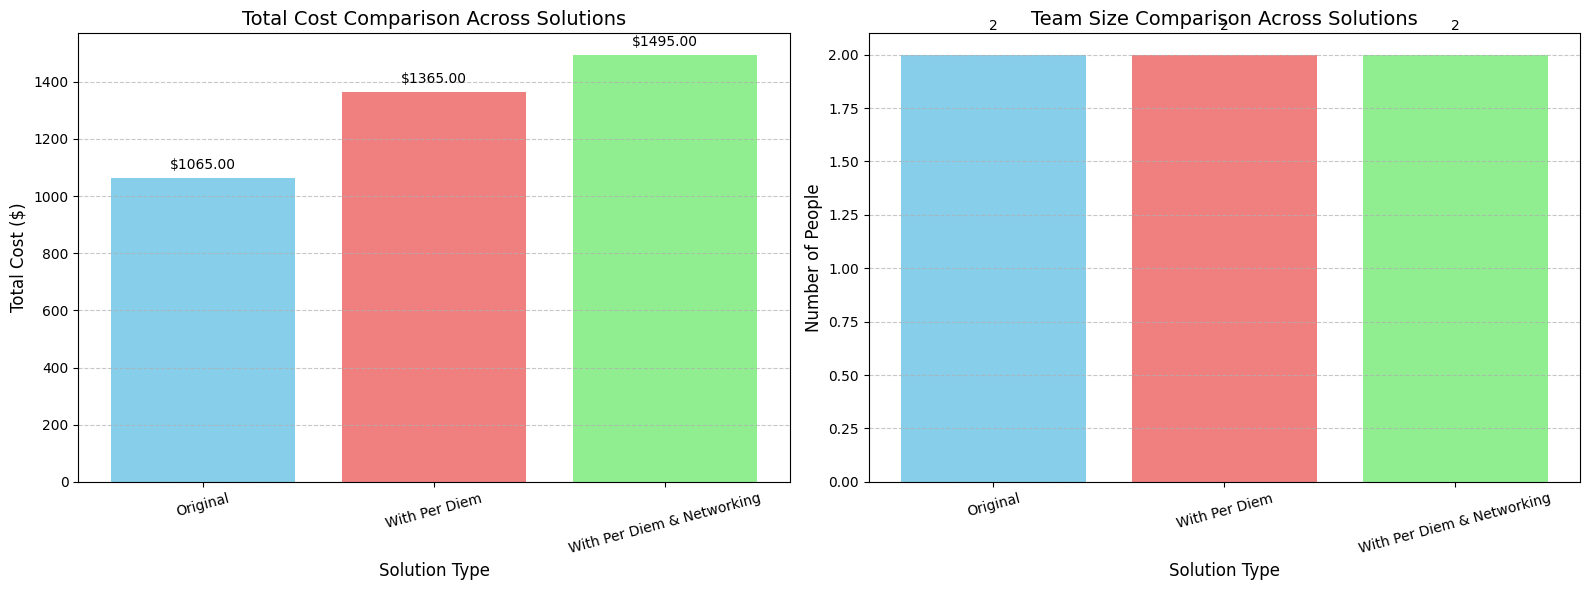


KEY TRADEOFFS AND INSIGHTS FROM STAKEHOLDER CONSIDERATIONS:
-------------------------------------------------------------------
- As new considerations (per diem, networking) are added, the total cost naturally increases.
- The core travel choices (lodging and flights) remained the same across all solutions, suggesting these were robustly optimal within the initial constraints and budget.
- Despite increasing costs, the team size remained constant at 2, indicating that the budget limit was tight enough that sending more people would exceed it, even before additional considerations.
- The initial budget of $1500 allowed for absorption of both per diem ($300) and networking costs ($130) without forcing a change in team size or a significant downgrade in travel/lodging quality (i.e., hotel rating, distance to venue).


In [119]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure all models are solved to get current values for comparison
model.solve()
model_per_diem.solve()
model_networking.solve()

# Get details for the original solution
original_solution = get_solution_details(model, solution_vars, num_people, lodging_df, flights_df, conference_dates, budget_limit, per_diem_per_day=0)

# Get details for the per diem solution
per_diem_solution = get_solution_details(model_per_diem, solution_vars_pd, num_people_pd, lodging_df, flights_df, conference_dates, budget_limit, per_diem_per_day)

# Get details for the networking solution (includes per diem)
networking_event_cost_per_person = 65 # Re-define for clarity in this cell
def get_networking_solution_details(model_obj, solution_vars_obj, num_people_var, lodging_df, flights_df, conference_dates, budget_limit, per_diem_per_day, networking_event_cost_per_person):
    status = LpStatus[model_obj.status]
    objective_value = value(model_obj.objective)
    team_size = int(value(num_people_var))

    selected_lodging_idx = None
    selected_flight_idx = None
    selected_team_size = None

    for (i, j, k), var in solution_vars_obj.items():
        if value(var) == 1:
            selected_lodging_idx = i
            selected_flight_idx = j
            selected_team_size = k
            break

    if selected_lodging_idx is None:
        return {"status": status, "objective_value": objective_value, "team_size": team_size, "found_solution": False}

    lodging_choice = lodging_df.iloc[selected_lodging_idx]
    flight_choice = flights_df.iloc[selected_flight_idx]

    if lodging_choice['lodging_type'] == 'Hotel':
        num_rooms = (selected_team_size + 1) // 2
        lodging_cost = lodging_choice['cost_per_night'] * conference_dates * num_rooms
    else:
        lodging_cost = lodging_choice['cost_per_night'] * conference_dates * selected_team_size

    flight_cost = flight_choice['cost'] * selected_team_size
    per_diem_cost = per_diem_per_day * conference_dates * selected_team_size
    networking_cost = networking_event_cost_per_person * selected_team_size
    total_cost = lodging_cost + flight_cost + per_diem_cost + networking_cost
    cost_per_person = total_cost / selected_team_size

    return {
        "status": status,
        "objective_value": objective_value,
        "team_size": selected_team_size,
        "lodging_name": lodging_choice['name'],
        "lodging_type": lodging_choice['lodging_type'],
        "lodging_cost_per_night": lodging_choice['cost_per_night'],
        "lodging_rating": lodging_choice['rating'],
        "lodging_distance": lodging_choice['distance_to_venue_miles'],
        "flight_airline": flight_choice['airline'],
        "flight_cost_per_person": flight_choice['cost'],
        "flight_stops": int(flight_choice['num_stops']),
        "flight_duration": flight_choice['flight_duration_hours'],
        "calculated_lodging_cost": lodging_cost,
        "calculated_flight_cost": flight_cost,
        "calculated_per_diem_cost": per_diem_cost,
        "calculated_networking_cost": networking_cost,
        "total_cost": total_cost,
        "budget_limit": budget_limit,
        "budget_remaining": budget_limit - total_cost,
        "cost_per_person": cost_per_person,
        "found_solution": True
    }

networking_solution = get_networking_solution_details(model_networking, solution_vars_net, num_people_net, lodging_df, flights_df, conference_dates, budget_limit, per_diem_per_day, networking_event_cost_per_person)

# Prepare data for plotting
solutions = ['Original', 'With Per Diem', 'With Per Diem & Networking']

total_costs = [
    original_solution['total_cost'],
    per_diem_solution['total_cost'],
    networking_solution['total_cost']
]

team_sizes = [
    original_solution['team_size'],
    per_diem_solution['team_size'],
    networking_solution['team_size']
]

# Create a DataFrame for easy plotting
comparison_df = pd.DataFrame({
    'Solution': solutions,
    'Total Cost': total_costs,
    'Team Size': team_sizes
})

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart for Total Cost
axes[0].bar(comparison_df['Solution'], comparison_df['Total Cost'], color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0].set_title('Total Cost Comparison Across Solutions', fontsize=14)
axes[0].set_ylabel('Total Cost ($)', fontsize=12)
axes[0].set_xlabel('Solution Type', fontsize=12)
axes[0].tick_params(axis='x', rotation=15)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
for index, value in enumerate(comparison_df['Total Cost']):
    axes[0].text(index, value + 20, f'${value:.2f}', ha='center', va='bottom', fontsize=10)

# Bar chart for Team Size
axes[1].bar(comparison_df['Solution'], comparison_df['Team Size'], color=['skyblue', 'lightcoral', 'lightgreen'])
axes[1].set_title('Team Size Comparison Across Solutions', fontsize=14)
axes[1].set_ylabel('Number of People', fontsize=12)
axes[1].set_xlabel('Solution Type', fontsize=12)
axes[1].tick_params(axis='x', rotation=15)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
for index, value in enumerate(comparison_df['Team Size']):
    axes[1].text(index, value + 0.1, f'{int(value)}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("\nKEY TRADEOFFS AND INSIGHTS FROM STAKEHOLDER CONSIDERATIONS:")
print("-------------------------------------------------------------------")
print("- As new considerations (per diem, networking) are added, the total cost naturally increases.")
print("- The core travel choices (lodging and flights) remained the same across all solutions, suggesting these were robustly optimal within the initial constraints and budget.")
print("- Despite increasing costs, the team size remained constant at 2, indicating that the budget limit was tight enough that sending more people would exceed it, even before additional considerations.")
print("- The initial budget of $1500 allowed for absorption of both per diem ($300) and networking costs ($130) without forcing a change in team size or a significant downgrade in travel/lodging quality (i.e., hotel rating, distance to venue).")

## Executive Summary

**Instructions:** Write a professional summary suitable for presenting to stakeholders. Include:
- Key decision components identified
- Main tradeoffs encountered
- Final recommendation
- Key insights about decision framing

---

### Key Decision Components

When planning the Vegs conference trip, the key decisions focused on selecting the optimal team size, flight options, and lodging for conference while balancing cost, quality, and networking. Key decision variables included the number of attendees (2 to 4), choice of flights (airline, cost, travel time), and lodging (price, rating, and distance from the venue). Key inputs consisted of airfare and hotel costs, availability, conference duration, per diem considerations, and stakeholder priorities. The primary objectives were to minimize total travel cost while maintaining adequate networking coverage and acceptable travel quality. These objectives were governed by hard constraints, including a $1,500 total budget, fixed conference dates, and a required team size range, as well as soft constraints related to comfort, travel convenience, and lodging proximity.

### Main Tradeoffs

Main tradeoffs were team size, where a larger team improved networking coverage but increased total cost, instead a smaller team was utilized. Higher-quality lodging and direct flights improved comfort and convenience but cost more, so a cheaper flight with a layover and travel time was selected to stay in budget. Similarly, hotels closer to the venue reduced transportation costs and travel burden at the expense of higher nightly rates. These tradeoffs required balancing cost efficiency against quality and effectiveness.

### Final Recommendation

Based on the optimization results, the recommended solution is to send two attendees to the conference, stay at the Grand Las Vegas Hotel, and book Spirit Airlines flights with one layover. This configuration results in a base total cost of 1,065, staying comfortably below the 1,500 budget. The additional considerations of per diem food buget and networking event expenses raised the total cost to 1,495 - right on budget. The solution provides sufficient networking coverage while preserving budget flexibility and minimizing financial risk.

### Key Insights About Decision Framing

I learned with this assignment to separate between objectives and constraints when framing decisions. Separating non-negotiable versus flexible allowed for realistic tradeoff analysis and better optimization outcomes. Treating convenience and comfort as soft constraints enabled the model to explore cost-saving options without violating feasibility.

---
**End of Assignment**